In [1]:
#!python -m spacy download en_core_web_sm

In [2]:
import os
from tqdm import tqdm
from collections import Counter
import re
import spacy 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import PIL.Image as Image
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import xml.etree.ElementTree as ET

from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import gaussian_kde
import matplotlib.cm as cm  # For colormap

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/raymondlab/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/raymondlab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raymondlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# get data
dfs = []
for city_csv in os.listdir('data'):
    temp_df = pd.read_csv(os.path.join('data', city_csv))
    temp_df['city'] = city_csv.replace('.csv', '')
    dfs.append(temp_df)
    
df = pd.concat(dfs, ignore_index=True)

In [4]:
# model configuration
model_id = "Qwen3-VL-30B-A3B-Instruct"

In [5]:
def fix_xml_tags(text):
    tag_re = re.compile(r"</?([a-zA-Z0-9_]+)>")
    result = []
    stack = []
    last_idx = 0

    for m in tag_re.finditer(text):
        # Copy text before this tag
        result.append(text[last_idx:m.start()])

        full_tag = m.group(0)
        name = m.group(1)
        is_closing = full_tag.startswith("</")

        if not is_closing:
            # Opening tag
            stack.append(name)
            result.append(full_tag)
        else:
            # Closing tag
            if stack and stack[-1] != name:
                # Mismatched closing tag: fix to match top of stack
                correct_name = stack[-1]
                result.append(f"</{correct_name}>")
                stack.pop()
            else:
                # Either matches or stack empty; keep as is
                result.append(full_tag)
                if stack:
                    stack.pop()

        last_idx = m.end()

    # Copy any trailing text after the last tag
    result.append(text[last_idx:])

    return "".join(result)

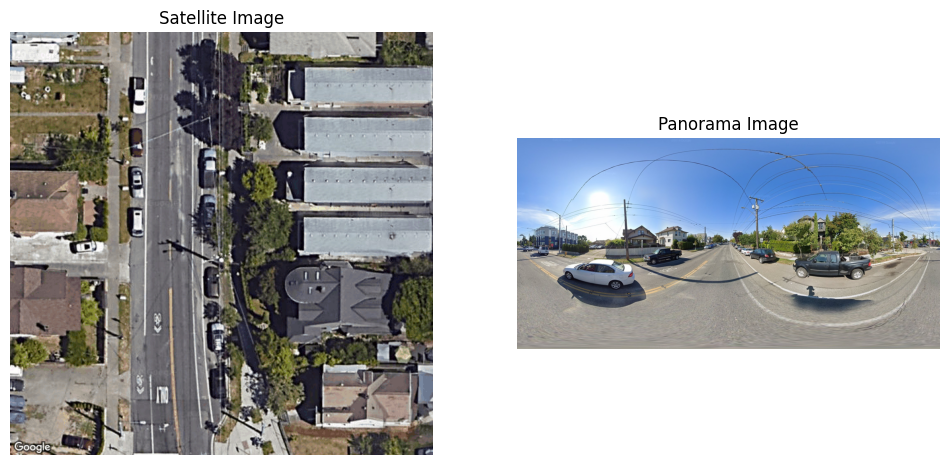

Satellite Image Generated Text:
 <satellite_scene>
  <distinctive_anchors>2-lane road with central yellow line, continuous row of parked cars on both sides, complex roof with multiple dormers and a circular window, large flat grey industrial roof, white house with a distinct curved roofline, intersection with a driveway leading to a garage, white car parked in a driveway, street with a bicycle lane marking.</distinctive_anchors>
  <roof_fingerprints>flat grey industrial roof, pitched red tile roof, complex residential roof with dormers, curved roofline with dark shingles, flat brown roof, brown shingled roof, grey flat roof, dark grey roof with circular window.</roof_fingerprints>
  <linear_sequence>continuous row of parked cars on the right side, residential houses with driveways and lawns on the left, continuous row of parked cars on the left side, large industrial buildings with flat roofs on the right, residential houses with various roof types on the left.</linear_sequence>
  <car

In [6]:
def process_generated_texts(satellite_path, panorama_path, display=True):
    # image and text display function
    if display:
        # subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        satellite_image = Image.open(satellite_path)
        axs[0].imshow(satellite_image)
        axs[0].axis('off')
        axs[0].set_title('Satellite Image')

        panorama_image = Image.open(panorama_path)
        axs[1].imshow(panorama_image)
        axs[1].axis('off')
        axs[1].set_title('Panorama Image')
        plt.show()

    city = satellite_path.split('/')[1]
    image_type = satellite_path.split('/')[2]

    file_path = os.path.join(image_type, model_id, city, image_type, satellite_path.split('/')[-1])

    with open(file_path.replace('.png', '.txt'), 'r') as f:
        sate_text = f.read()

    city = panorama_path.split('/')[1]
    image_type = panorama_path.split('/')[2]

    file_path = os.path.join(image_type, model_id, city, image_type, panorama_path.split('/')[-1])

    with open(file_path.replace('.jpg', '.txt'), 'r') as f:
        pano_text = f.read()
    if display:
        print("Satellite Image Generated Text:\n", sate_text)
        print("\nPanorama Image Generated Text:\n", pano_text)
    sate_text = fix_xml_tags(sate_text)
    pano_text = fix_xml_tags(pano_text)
    return ET.fromstring(sate_text), ET.fromstring(pano_text)

# Example usage of this function
satellite = os.path.join('VIGOR', df['city'].iloc[0], 'satellite', df['satellite'].iloc[0])
panorama = os.path.join('VIGOR', df['city'].iloc[0], 'panorama', df['panorama'].iloc[0])

sate_text, pano_text = process_generated_texts(satellite, panorama)

In [7]:
satellite_keys = [
    "distinctive_anchors",
    "roof_fingerprints",
    "linear_sequence",
    "cardinal_orientation",
    "road_geometry",
    "shadow_analysis"
]
ground_keys = [
    "road_topology_360",
    "sector_forward",
    "sector_backward",
    "spatial_layout",
    "road_markings",
    "orientation_cues",
    "distinctive_anchors",
    "environmental_context"
]



In [8]:
# lemmatization function
def preprocessing_lemmatizer(generated_text, keys):
    data = {}
    
    for key in keys:
        text = generated_text.find(key).text
        # https://www.geeksforgeeks.org/nlp/removing-stop-words-nltk-python/
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        tokens = word_tokenize(text)

        filtered_tokens = [word.strip() for word in tokens if word not in stop_words]
        filtered_tokens = [word for word in filtered_tokens if word.isalnum()]
        lemmatizer = WordNetLemmatizer()

        tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]
        data[key] = " ".join(tokens)
    return data
sate_data = preprocessing_lemmatizer(sate_text, satellite_keys)
pano_data = preprocessing_lemmatizer(pano_text, ground_keys)


In [9]:
sate_data

{'distinctive_anchors': 'road central yellow line continuous row parked car side complex roof multiple dormer circular window large flat grey industrial roof white house distinct curved roofline intersection driveway leading garage white car parked driveway street bicycle lane marking',
 'roof_fingerprints': 'flat grey industrial roof pitched red tile roof complex residential roof dormer curved roofline dark shingle flat brown roof brown shingled roof grey flat roof dark grey roof circular window',
 'linear_sequence': 'continuous row parked car right side residential house driveway lawn left continuous row parked car left side large industrial building flat roof right residential house various roof type left',
 'cardinal_orientation': 'road run strictly',
 'road_geometry': 'road central yellow line bicycle lane marking right side median strip continuous row parked car side visible turn arrow crosswalk',
 'shadow_analysis': 'long shadow cast south indicating tall structure shadow consis

In [10]:
pano_data

{'road_topology_360': 'road continues straight ahead forming continuous street left right edge image meet rear scene indicating straight road immediate intersection turn suggesting continuous path forward backward',
 'sector_forward': 'straight asphalt road extends forward marked double yellow center line road flanked residential house lawn driveway left building blue white facade visible right black pickup truck parked line tree shrub border sidewalk sky clear blue sun high sky indicating midday',
 'sector_backward': 'rear view show continuation road white car black pickup truck visible left right side respectively road curve slightly right distance parked car visible along curb sky remains clear blue consistent forward view',
 'spatial_layout': 'left side sequence building residential house parked car right side sequence parked black pickup truck residential house tree shrub parked car',
 'road_markings': 'double yellow center line white stop bar intersection bike lane marking left s

In [11]:
city_dict = {city: None for city in df['city'].unique()}

for city in df['city'].unique():
    satellite_all = {satellite_keys[i]: [] for i in range(len(satellite_keys))}
    panorama_all = {ground_keys[i]: [] for i in range(len(ground_keys))}
    # vectorization for each image type
    for i, row in df[df['city'] == city].iterrows():

        satellite = os.path.join('VIGOR', row['city'], 'satellite', row['satellite'])
        panorama = os.path.join('VIGOR', row['city'], 'panorama', row['panorama'])

        try:
            sate_text, pano_text = process_generated_texts(satellite, panorama, display=False)
            
            sate_data = preprocessing_lemmatizer(sate_text, satellite_keys)
            pano_data = preprocessing_lemmatizer(pano_text, ground_keys)

            for key in satellite_keys:
                satellite_all[key].append(sate_data[key])  
            for key in ground_keys:
                panorama_all[key].append(pano_data[key])  
        except Exception as e:

            print(f"Error processing {satellite} and {panorama}: {e}")  
    city_dict[city] = {'satellite': satellite_all, 'panorama': panorama_all}

Error processing VIGOR/Seattle/satellite/satellite_47.5727402603687_-122.32873167114155.png and VIGOR/Seattle/panorama/9g4ZB5ACUzA3nwTUnRuIMQ,47.572901,-122.328972,.jpg: junk after document element: line 10, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.59865798412707_-122.31657056535768.png and VIGOR/Seattle/panorama/3SFUMI8jHBwP7XbMEJyoxg,47.598530,-122.316360,.jpg: junk after document element: line 10, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.57930170942145_-122.32143500767124.png and VIGOR/Seattle/panorama/HpR41Up08zPD4pVEHji5FA,47.579366,-122.321372,.jpg: 'NoneType' object has no attribute 'text'
Error processing VIGOR/Seattle/satellite/satellite_47.585207013568926_-122.29516701917808.png and VIGOR/Seattle/panorama/yV6mnWmSzIqBMc17SlQyxw,47.585254,-122.295120,.jpg: junk after document element: line 18, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.57864556451617_-122.30830101342465.png and VIGOR/Seattle/panorama/PvyKueEfOAIc9

Error processing VIGOR/Seattle/satellite/satellite_47.575364839989795_-122.28932968840182.png and VIGOR/Seattle/panorama/X8XRYcqi1-E48FkayESd8g,47.575223,-122.289537,.jpg: junk after document element: line 18, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.606203650537736_-122.29224835378994.png and VIGOR/Seattle/panorama/ZxFLNalEyEncuu-uociVbw,47.606155,-122.292071,.jpg: 'NoneType' object has no attribute 'text'
Error processing VIGOR/Seattle/satellite/satellite_47.6085001577062_-122.33116389229833.png and VIGOR/Seattle/panorama/smOHkzsicAbYwCGkO38jmQ,47.608438,-122.331015,.jpg: junk after document element: line 10, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.60029834639026_-122.29127546532725.png and VIGOR/Seattle/panorama/Co4HJHq4QieDPqnSQEh_JA,47.600223,-122.291256,.jpg: 'NoneType' object has no attribute 'text'
Error processing VIGOR/Seattle/satellite/satellite_47.59832991167443_-122.32435367305936.png and VIGOR/Seattle/panorama/2-p2vxy_3FJjWEHyD

In [12]:
for city in city_dict:
    print(f"City: {city}")
    satellite_all = city_dict[city]['satellite'][satellite_keys[0]]
    panorama_all = city_dict[city]['panorama'][ground_keys[0]]
    print(f"Correct Formatting: {len(satellite_all)}/2500")

City: Seattle
Correct Formatting: 1526/2500
City: NewYork
Correct Formatting: 1415/2500
City: SanFrancisco
Correct Formatting: 1543/2500
City: Chicago
Correct Formatting: 1521/2500


In [13]:
def find_noun_noun_bigrams(texts, min_freq=3, top_n=50):
    bigram_counts = Counter()

    for text in texts:
        doc = nlp(text.lower())
        for i in range(len(doc) - 1):
            t1, t2 = doc[i], doc[i+1]
            if t1.pos_ == "NOUN" and t2.pos_ == "NOUN":
                bigram = f"{t1.lemma_.lower()} {t2.lemma_.lower()}"
                bigram_counts[bigram] += 1

    # keep only reasonably frequent ones
    common = [bg for bg, c in bigram_counts.items() if c >= min_freq]
    # optionally sort and cut to top_n
    common = sorted(common, key=lambda bg: bigram_counts[bg], reverse=True)[:top_n]
    return set(common)
def extract_noun_tokens_with_phrases(text, common_bigrams):
    doc = nlp(text.lower())
    tokens = []
    i = 0

    while i < len(doc):
        # Try to match a NOUN–NOUN bigram
        if i < len(doc) - 1:
            t1, t2 = doc[i], doc[i+1]
            if t1.pos_ == "NOUN" and t2.pos_ == "NOUN":
                bigram = f"{t1.lemma_.lower()} {t2.lemma_.lower()}"
                if bigram in common_bigrams:
                    tokens.append(bigram.replace(" ", "_"))  # parking_lot
                    i += 2
                    continue  # skip t2 completely

        # Otherwise, if this token is a NOUN, keep it as single noun
        if doc[i].pos_ == "NOUN":
            tokens.append(doc[i].lemma_.lower())
        i += 1

    return tokens

def bag_of_words(texts, top_n=20, min_freq_bigram=3):
    # 1) find common noun–noun bigrams across corpus
    common_bigrams = find_noun_noun_bigrams(texts, min_freq=min_freq_bigram, top_n=50)

    # 2) turn each text into a list of tokens (nouns + merged noun phrases)
    tokenized_texts = [
        extract_noun_tokens_with_phrases(text, common_bigrams)
        for text in texts
    ]

    # 3) Use CountVectorizer with pre-tokenized input
    vectorizer = CountVectorizer(
        analyzer=lambda x: x  # x is already a list of tokens
    )
    bow_matrix = vectorizer.fit_transform(tokenized_texts)
    vocab = vectorizer.get_feature_names_out()
    freq = bow_matrix.sum(axis=0).A1

    top_idx = np.argsort(freq)[::-1][:top_n]
    return [(vocab[i], freq[i]) for i in top_idx]

In [14]:
common_landmarks = None
os.system("mkdir results_new")
os.system("rm -r results_new/satellite_result")
os.system("mkdir results_new/satellite_result")

os.system("mkdir results_new/satellite_result/count_vectorizer")
for city in city_dict:
    satellite_all = city_dict[city]['satellite']
    os.system(f"mkdir results_new/satellite_result/count_vectorizer/{city}")
    for key in satellite_keys:
        top_words = bag_of_words(satellite_all[key], top_n=20)
        with open(f'results_new/satellite_result/count_vectorizer/{city}/{key}.txt', 'w') as f:
            words = []
            for word, freq in top_words:
                print(f"{word}: {freq}", file=f)
                words.append(word)
            if key == 'distinctive_anchors':
                if common_landmarks is None:
                    common_landmarks = set(words)
                else:
                    common_landmarks = common_landmarks.intersection(set(words))


        

mkdir: cannot create directory ‘results_new’: File exists


In [15]:
city_satellite_landmarks = {}
# get values
for city in city_dict:
    satellite_all = city_dict[city]['satellite']['distinctive_anchors']
    top_words = bag_of_words(satellite_all, top_n=20)
    words = {}
    for word, freq in top_words:
        if word in common_landmarks:
            words[word] = freq
    city_satellite_landmarks[city] = words
city_satellite_landmarks

{'Seattle': {'roof': 1249,
  'parking_lot': 654,
  'car': 646,
  'road': 557,
  'intersection': 532,
  'tree': 526,
  'building': 481,
  'street': 451,
  'vehicle': 347,
  'row': 276,
  'structure': 228,
  'crosswalk': 159},
 'NewYork': {'roof': 1078,
  'building': 742,
  'intersection': 637,
  'street': 579,
  'parking_lot': 571,
  'car': 427,
  'road': 376,
  'crosswalk': 282,
  'structure': 262,
  'row': 243,
  'tree': 240,
  'vehicle': 233},
 'SanFrancisco': {'roof': 1472,
  'intersection': 795,
  'building': 768,
  'car': 745,
  'parking_lot': 721,
  'road': 617,
  'street': 600,
  'row': 402,
  'tree': 375,
  'crosswalk': 284,
  'vehicle': 262,
  'structure': 225},
 'Chicago': {'roof': 1124,
  'parking_lot': 898,
  'building': 748,
  'car': 723,
  'road': 551,
  'tree': 441,
  'intersection': 402,
  'row': 392,
  'street': 380,
  'vehicle': 312,
  'structure': 277,
  'crosswalk': 142}}

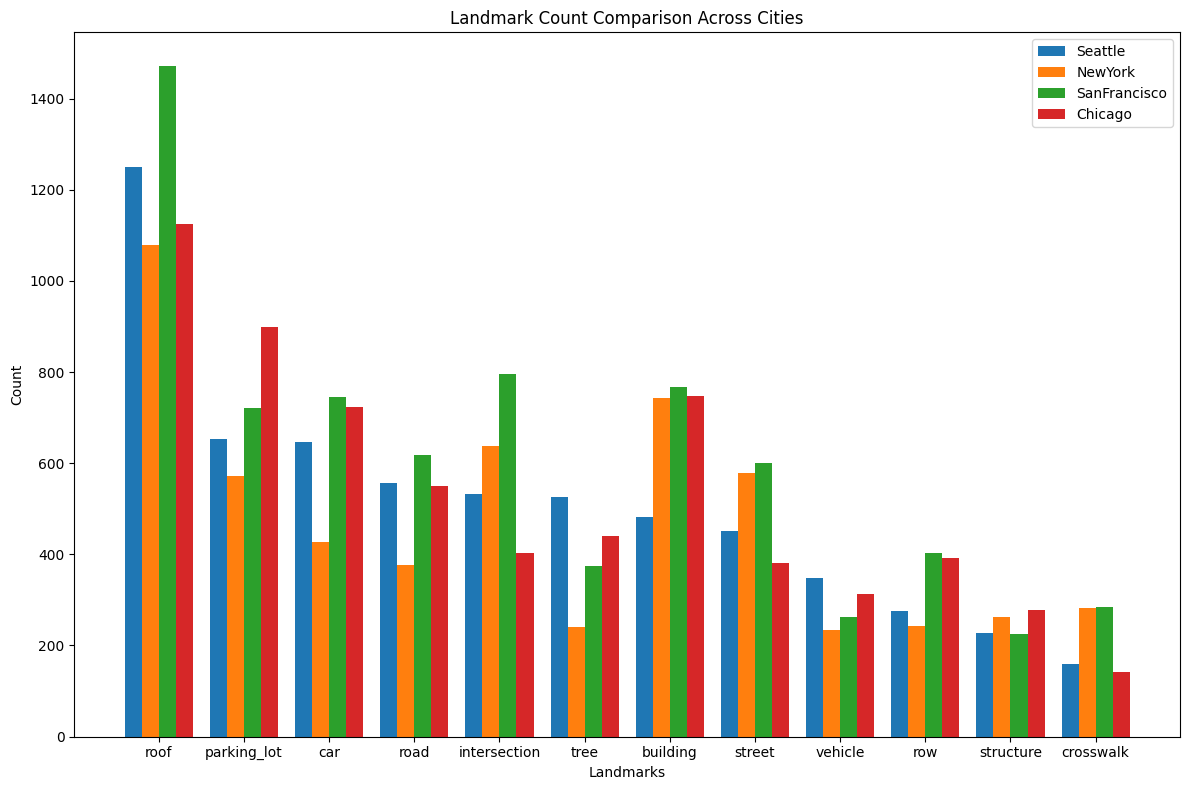

In [16]:

cities = list(city_satellite_landmarks.keys())
landmarks = list(next(iter(city_satellite_landmarks.values())).keys())

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(landmarks))

for i, city in enumerate(cities):
    counts = [city_satellite_landmarks[city][landmark] for landmark in landmarks]
    ax.bar(index + i * bar_width, counts, width=bar_width, label=city)

ax.set_xlabel('Landmarks')
ax.set_ylabel('Count')
ax.set_title('Landmark Count Comparison Across Cities')
ax.set_xticks(index + bar_width * (len(cities) - 1) / 2)
ax.set_xticklabels(landmarks)
ax.legend()

plt.tight_layout()
plt.show()